<a href="https://colab.research.google.com/github/loaiwalid07/main/blob/main/Intrusion_Detection_on_UNSBW_NB15_by_using_Machine_Learning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 style=' border:1;'><center>Intrusion Detection on UNSBW-NB15 by using Machine Learning Techniques</center></h1>





----

#Import Important Pacages

In [ ]:
!pip install -q sklearn_som 
!pip install -q git+https://github.com/giuliano-oliveira/gdown_folder.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import pandas as pd
import numpy as np
import random
import gdown
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,normalize,OneHotEncoder
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import StackingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,cross_validate, train_test_split, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report,roc_curve, roc_auc_score
from sklearn.manifold import TSNE
from sklearn_som.som import SOM
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from tqdm import trange

# **Load the dataset**

In [ ]:
for i in trange(1):
  !gdown --id 1yafPDtNnSxCcYqhE5VhCMTUPk8PGfTXm
  !gdown --id 19EBDKZ1WrFDSqEiIpmgUL3h84jqC2CbQ

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading...
From: https://drive.google.com/uc?id=1yafPDtNnSxCcYqhE5VhCMTUPk8PGfTXm
To: /content/UNSW_NB15_.csv
100% 15.4M/15.4M [00:00<00:00, 263MB/s]
Downloading...
From: https://drive.google.com/uc?id=19EBDKZ1WrFDSqEiIpmgUL3h84jqC2CbQ
To: /content/train-set_UNSW_NB15_.csv
100% 32.3M/32.3M [00:00<00:00, 199MB/s]


100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


In [ ]:
train_set = pd.read_csv("./train-set_UNSW_NB15_.csv") #, header = None
test_set = pd.read_csv("./UNSW_NB15_.csv") 

# **Data Cleaning & Prepocessing**

In [ ]:
'''
Checkng for nulls and drop duplicated values 
'''
(train_set =='-').sum()

test_set.isnull().sum().sum()

print(Counter(train_set.attack_cat))

bin_labels = pd.value_counts(train_set['label'], sort = True)
bin_labels.rename(index={0:'Normal',1:'Attack'})
multi_labels = pd.value_counts(train_set['attack_cat'], sort = True)

train_set.duplicated().sum()

train_set['service'].replace('-',np.nan,inplace=True)
train_set.dropna(inplace=True)

test_set['service'].replace('-',np.nan,inplace=True)
test_set.dropna(inplace=True)

train_set.isnull().sum().sum()

Counter({'Normal': 56000, 'Generic': 40000, 'Exploits': 33393, 'Fuzzers': 18184, 'DoS': 12264, 'Reconnaissance': 10491, 'Analysis': 2000, 'Backdoor': 1746, 'Shellcode': 1133, 'Worms': 130})


0

In [ ]:
duplicate = test_set[test_set.duplicated()]
duplicate
print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label


In [ ]:
train_set = train_set.drop([ 'stcpb', 'dtcpb', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd','id'], axis=1) # droped label
test_set = test_set.drop([ 'stcpb', 'dtcpb', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd','id'], axis=1) # droped label


# train_set.info()

**Data Insights**

/n


Text(0, 0.5, 'Frequency')

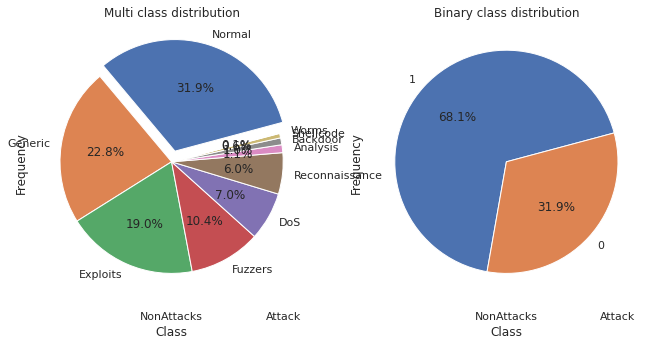

In [ ]:
# Mutli Plot

labels = ['NonAttacks','Attack']
my_explode = [0.1,0,0,0,0,0,0,0,0,0]
plt.subplot(1, 2, 1)
multi_labels.plot(kind = 'pie', rot=0,figsize=(11, 6), explode=my_explode, autopct='%1.1f%%', startangle=15,)
plt.title("Multi class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
print('/n')

# Binary Plot
plt.subplot(1, 2, 2)
bin_labels.plot(kind = 'pie', rot=0,figsize=(11, 6),autopct='%1.1f%%', startangle=15,)
plt.title("Binary class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")


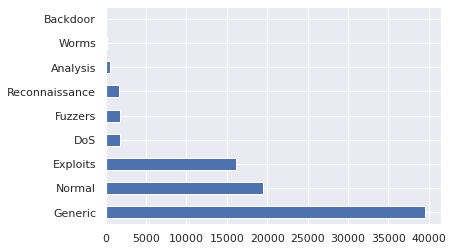

In [ ]:
train_set.attack_cat.value_counts().plot.barh()

In [ ]:
train_set.attack_cat.value_counts()

Generic           39496
Normal            19488
Exploits          16187
DoS                1791
Fuzzers            1731
Reconnaissance     1703
Analysis            564
Worms               114
Backdoor             99
Name: attack_cat, dtype: int64

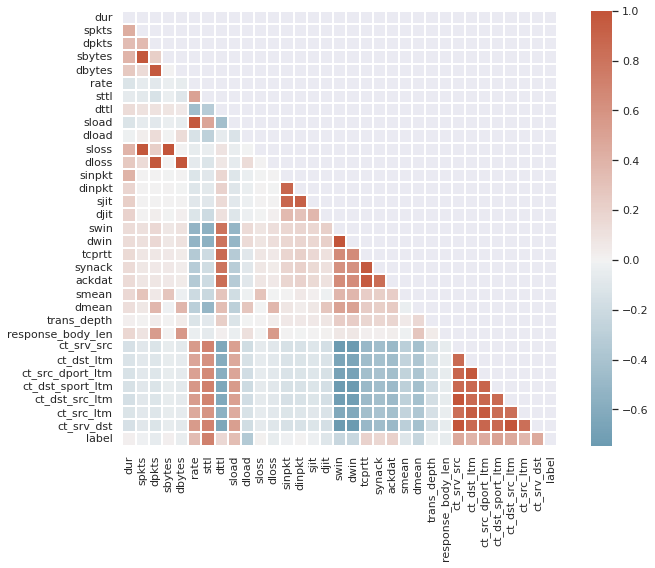

In [ ]:
import seaborn as sns
corr = train_set.corr()

sns.set_theme('notebook')

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=1.)


In [ ]:
#drop Normal Cat from train set
remove = train_set[train_set['attack_cat']=='Normal'].index
train_set = train_set.drop(remove)

In [ ]:
#drop Normal Cat from test set

remove = test_set[test_set['attack_cat']=='Normal'].index
test_set = test_set.drop(remove)

Y_test = test_set.attack_cat

X_test = test_set.drop(['label'], axis=1) #, 'attack_cat'

# transfer with label encoding
X_test = X_test.apply(LabelEncoder().fit_transform)

In [ ]:
pd.set_option('display.max_columns', None)

isna = pd.DataFrame(train_set.isna().sum().values.reshape(1, 37), columns=train_set.columns, index=['NA'])
isnull = pd.DataFrame(train_set.isnull().sum().values.reshape(1, 37), columns=train_set.columns, index=['Null'])

print(pd.concat([isna, isnull]).sum().sum())
pd.concat([isna, isnull])

0


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,label
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Feature Selection**

In [ ]:
#Preprocessing (transformation/scaling)

le = LabelEncoder()
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()

vector = data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

data['attack_cat'] = le1.fit_transform(vector)
data['proto'] =   le.fit_transform(data['proto'])
data['service'] = le1.fit_transform(data['service'])
data['state'] =   le2.fit_transform(data['state'])
#data['srcip'] = le.fit_transform(data['srcip'])
#data['dstip'] = le.fit_transform(data['dstip'])

print('\nDescribing attack_type: ')
data['attack_cat'].describe()

attack cat: {'Shellcode', 'Generic', 'Analysis', 'Worms', 'Normal', 'Reconnaissance', 'DoS', 'Fuzzers', 'Exploits', 'Backdoor'}

Describing attack_type: 


count    82332.000000
mean         4.987757
std          1.431541
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          9.000000
Name: attack_cat, dtype: float64

In [ ]:
#To show the headers of the data
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [ ]:
#X = data.drop(['id','attack_cat','label', 'stcpb', 'dtcpb', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd'], axis=1) # droped label
#X = data[varr]

X = data.drop(['id','attack_cat','label'], axis=1) 
y = data['attack_cat']
X

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000011,117,0,4,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
1,0.000008,117,0,4,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
2,0.000005,117,0,4,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0
3,0.000006,117,0,4,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0
4,0.000010,117,0,4,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,117,0,4,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0
82328,1.106101,111,0,3,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.7,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0
82329,0.000000,6,0,4,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1
82330,0.000000,6,0,4,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.0,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1


In [ ]:
x_attck = []
y_attck = []
for i in range(len(y)):
  if y[i] == 1 :
    y_attck.append(y[i])
    x_attck.append(X.iloc[i])

# **Binary Model**

In [ ]:
#Split the data set to use olny normal data

num_col = train_set.select_dtypes(include='number').columns
len(num_col)

cat_col = train_set.columns.difference(num_col)
cat_col = cat_col.drop(['attack_cat'])

print(num_col.shape)
train_cat = train_set[cat_col].copy()

train_cat = pd.get_dummies(train_cat,columns=cat_col)
print(train_cat.shape)


train_num = train_set[num_col].copy()




data = pd.concat([train_set, train_cat],axis=1)
print(data.shape)

data.drop(columns=cat_col,inplace=True)
print(data.shape)


# data.info()
# num_col
# data.shape

data = data.drop(['state_RST'], axis=1) 

print(data.shape)

(33,)
(81173, 19)
(81173, 56)
(81173, 53)
(81173, 52)


In [ ]:
# Split the data set
Y = train_set.label
X = train_set.drop(['label', 'attack_cat'], axis=1)

# transfer with label encoding
X = X.apply(LabelEncoder().fit_transform)

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, shuffle=True,random_state=42)

In [ ]:
Y.value_counts()

1    61685
0    19488
Name: label, dtype: int64

In [ ]:
# Function for plot ROC curve
from yellowbrick.classifier import ROCAUC

encode_label = le3.fit_transform(Y.unique())
dict_code = dict(zip(y.unique(),encode_label))

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
    try:                                    
      # Fitting to the training data first then scoring with the test data                                    
      visualizer.fit(xtrain, ytrain)
      visualizer.score(xtest, ytest)
      g= visualizer.show()
    except AttributeError:
      pass
    return 

**Random Forest**

In [ ]:
#criterion="gini",max_depth=20,min_samples_leaf=4,min_samples_split=5,random_state=42, n_jobs=-1
rf = RandomForestClassifier(criterion="gini",max_depth=20,min_samples_leaf=4,min_samples_split=5,random_state=42, n_jobs=-1)
rf.fit(X_train,y_train).score(X_val,y_val)

0.9868801971050201

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



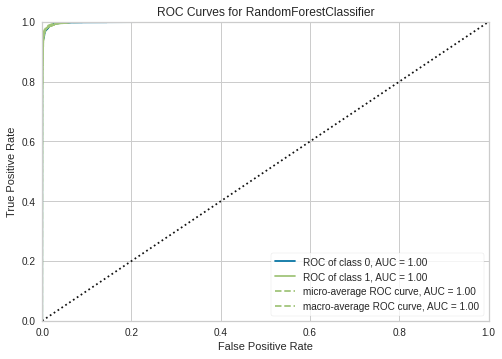

In [ ]:
plot_ROC_curve(rf, X_train, y_train,X_val,y_val)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.99     16235
   macro avg       0.99      0.98      0.98     16235
weighted avg       0.99      0.99      0.99     16235



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



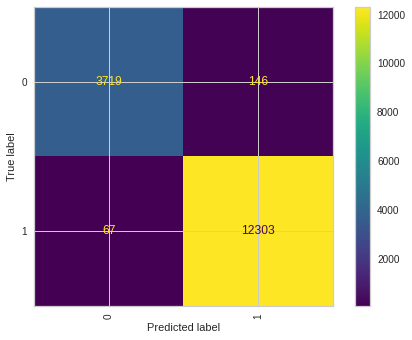

In [ ]:
#Results
print(classification_report(y_val,rf.predict(X_val)))

#plot confusion matrix
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")
plt.show()

In [ ]:
varr,fet=[],[]
for i in range(len(X_train.columns)):
  if rf.feature_importances_[i] > 0.04:
    fet.append(rf.feature_importances_[i])
    varr.append(X_train.columns[i])
import_fet=pd.DataFrame({ "Varname": varr, "Imp": fet}) 
import_fet.sort_values(by="Imp", ascending=False)

**XGB Classifier**

In [ ]:
model_xgb = XGBClassifier(learning_rate=,n_estimators=,max_depth=,
                          ,n_jobs=-1)
model_xgb.fit(X_train, y_train).score(X_val, y_val)

0.9844779796735448

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.97      0.98     16235
weighted avg       0.98      0.98      0.98     16235



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



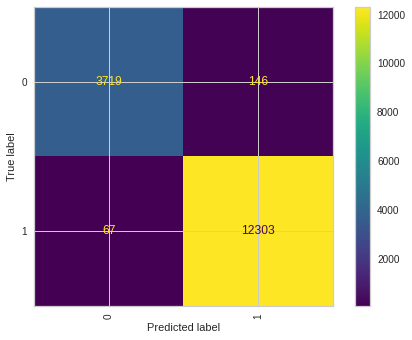

In [ ]:
print(classification_report(y_val,model_xgb.predict(X_val)))
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")  
plt.show()

**Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier(max_depth=12,min_samples_leaf=3,min_samples_split=7,random_state=42)
dt.fit(X_train, y_train).score(X_val, y_val)

0.983615645210964

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.98      0.98      0.98     16235



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



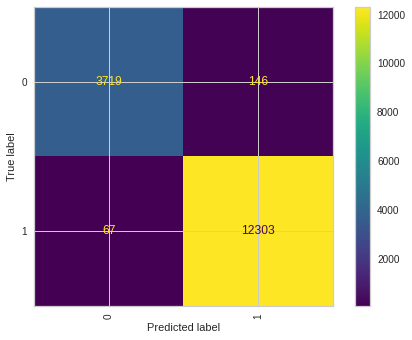

In [ ]:
print(classification_report(y_val,dt.predict(X_val)))
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")  
plt.show()

**SVM**

In [ ]:
svm_cls= svm.SVC()
svm_cls.fit(X_train,y_train)
predicted_svm = svm_cls.predict(X_val)
print("Accuracy for SVM :-> ",np.mean(predicted_svm == y_val))
print(metrics.classification_report(y_val, predicted_svm))

Accuracy for SVM :->  0.9764705882352941
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3865
           1       0.97      1.00      0.98     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.95      0.97     16235
weighted avg       0.98      0.98      0.98     16235



**Bagging**

In [ ]:
bag = BaggingClassifier(svm_cls,random_state=0)
bag.fit(X_train, y_train).score(X_val,y_val)

0.9764705882352941

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3865
           1       0.97      1.00      0.98     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.95      0.97     16235
weighted avg       0.98      0.98      0.98     16235



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



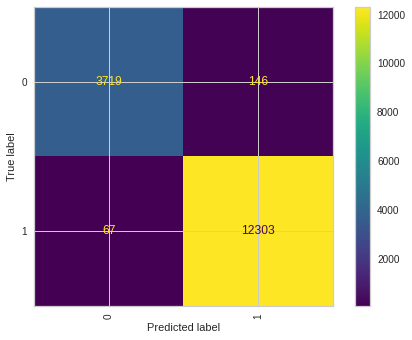

In [ ]:
print(classification_report(y_val,bag.predict(X_val)))
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")  
plt.show()

**Stacking**

In [ ]:
models = [
    ("bag", BaggingClassifier(svm_cls, random_state=0)),
    ("xgb",XGBClassifier()),
    ("dt", make_pipeline(DecisionTreeClassifier(max_depth=15))),
    ('rf', RandomForestClassifier())
    ]

stacking = StackingClassifier(estimators=models,final_estimator=RandomForestClassifier(),cv=5)
stacking.fit(X_train, y_train).score( X_val, y_val)

0.9833692639359408

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.98      0.98      0.98     16235



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



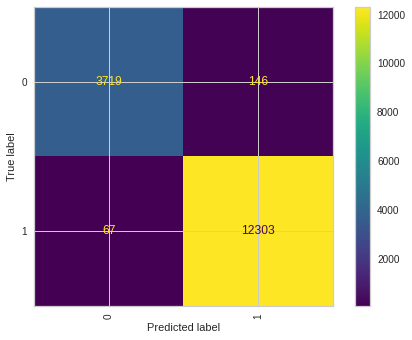

In [ ]:
print(classification_report(y_val,stacking.predict(X_val)))
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")  
plt.show()

# **Multiclass Model**